## Analysis of Airbnb Seattle:
    
Understanding the business : 
    
    There are 3 data files (in CSV format) to be looked into.
    
    listing.csv - includes the specifc infomation about the listing such as its neighbourhood, amenity, picture_url, host information, review score etc.
    calendar.csv, which includes all the listing price of the airbnb housing from Jan1st 2016 to Jan 7th, 2017

    

    There are three questions I try to explore from these datasets

What are the busiest times of the year to visit Seattle? By how much do prices spike?
Can we use other listing information to predict the housing price?
The vibe of each Seattle neighborhood using listing descriptions?


Part 1: Analyze price over other groups of features

Part 2 : How is price varying during various times of the year

Part 3 : Determine the features that can be useful to regression model and find out the r-squared. 

In [39]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns; sns.set()
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, average_precision_score, classification_report, confusion_matrix, f1_score
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.cross_validation import train_test_split

seattle_lists = pd.read_csv('./listings.csv')
calendar =  pd.read_csv('./calendar.csv') 
reviews = pd.read_csv('./reviews.csv')

# seattle_lists.columns

### Numerical features assessment

Numerical (float types) features considered initially are :

host_listings_count,host_total_listings_count,latitude,longitude,bathrooms,bedrooms,beds,square_feet,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,reviews_per_month

Features that aren't listed here have been eliminated either due to the values that seem not to be correlated to the price or irrelevant to the price.

In [40]:
num_cols_of_interest = "price,host_listings_count,host_total_listings_count,bathrooms,bedrooms,beds,guests_included,\
review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,\
review_scores_location,review_scores_value,reviews_per_month".split(",")

clean_num_data = seattle_lists[num_cols_of_interest]
clean_num_data = clean_num_data.dropna(axis=0)

# Reading all rows and features from clean_num_data except for price into x-axis
X = clean_num_data.iloc[:, 1:]

# Taking dependent variable price into the y-axis
y = clean_num_data.iloc[:, 0].replace('[\$,]','',regex=True).astype(float)

# Using selectkbest with chi2, performing a fit to see the top 10 features related to price
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature', 'Score']
print(featureScores.nlargest(10, 'Score'))

                      Feature          Score
0         host_listings_count  112708.261118
1   host_total_listings_count  112708.261118
4                        beds    1238.200738
5             guests_included    1124.870138
3                    bedrooms    1014.026284
13          reviews_per_month     792.697961
2                   bathrooms     396.517870
6        review_scores_rating     136.175090
8   review_scores_cleanliness      17.123854
7      review_scores_accuracy      16.394258


In [41]:
reviews = reviews.drop('id', axis=1)
reviews.rename(columns={'listing_id':'id'}, inplace=True)
# print(reviews.head())

# print(num_cols_of_interest)
num_cols_of_interest.append('id')
num_cols_of_interest.append('neighbourhood_group_cleansed')
seattle_cleaned = seattle_lists[num_cols_of_interest]
seattle_cleaned.head()

,price,host_listings_count,host_total_listings_count,bathrooms,bedrooms,beds,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,id,neighbourhood_group_cleansed
0,$85.00,3.0,3.0,1.0,1.0,1.0,2,95.0,10.0,10.0,10.0,10.0,9.0,10.0,4.07,241032,Queen Anne
1,$150.00,6.0,6.0,1.0,1.0,1.0,1,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1.48,953595,Queen Anne
2,$975.00,2.0,2.0,4.5,5.0,7.0,10,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1.15,3308979,Queen Anne
3,$100.00,1.0,1.0,1.0,0.0,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7421966,Queen Anne
4,$450.00,2.0,2.0,2.0,3.0,3.0,6,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0.89,278830,Queen Anne


In [42]:

merged_df = pd.merge(reviews, seattle_cleaned, on='id')
merged_df.head()

zero_fills = lambda col: col.fillna(0)

merged_fill_df = merged_df.apply(zero_fills, axis=0)
merged_fill_df['price'] = merged_fill_df['price'].replace('[\$,]','',regex=True).astype(float)
merged_fill_df['date'] = pd.to_datetime(merged_fill_df['date'])
# merged_fill_df.head()

for col in merged_fill_df.columns.tolist()[1:]:
#     print(col, " - ", merged_fill_df[col].dtypes)
    if merged_fill_df[col].dtypes in ('float64', 'int64'):
        merged_fill_df = merged_fill_df.ix[merged_fill_df[col] > 0]

merged_fill_df.head()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


,id,date,reviewer_id,reviewer_name,comments,price,host_listings_count,host_total_listings_count,bathrooms,bedrooms,...,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,neighbourhood_group_cleansed
0,7202016,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,75.0,1.0,1.0,1.0,1.0,...,1,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2.82,Queen Anne
1,7202016,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,75.0,1.0,1.0,1.0,1.0,...,1,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2.82,Queen Anne
2,7202016,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",75.0,1.0,1.0,1.0,1.0,...,1,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2.82,Queen Anne
3,7202016,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,75.0,1.0,1.0,1.0,1.0,...,1,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2.82,Queen Anne
4,7202016,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,75.0,1.0,1.0,1.0,1.0,...,1,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2.82,Queen Anne


In [43]:
merged_fill_df['neighbourhood_group_cleansed'].unique()

array(['Queen Anne', 'Central Area', 'Cascade', 'Other neighborhoods',
       'Capitol Hill', 'Ballard', 'Delridge', 'Downtown', 'West Seattle',
       'University District', 'Seward Park', 'Northgate', 'Beacon Hill',
       'Rainier Valley', 'Interbay', 'Lake City', 'Magnolia'], dtype=object)

Text(0,0.5,'Price Count')

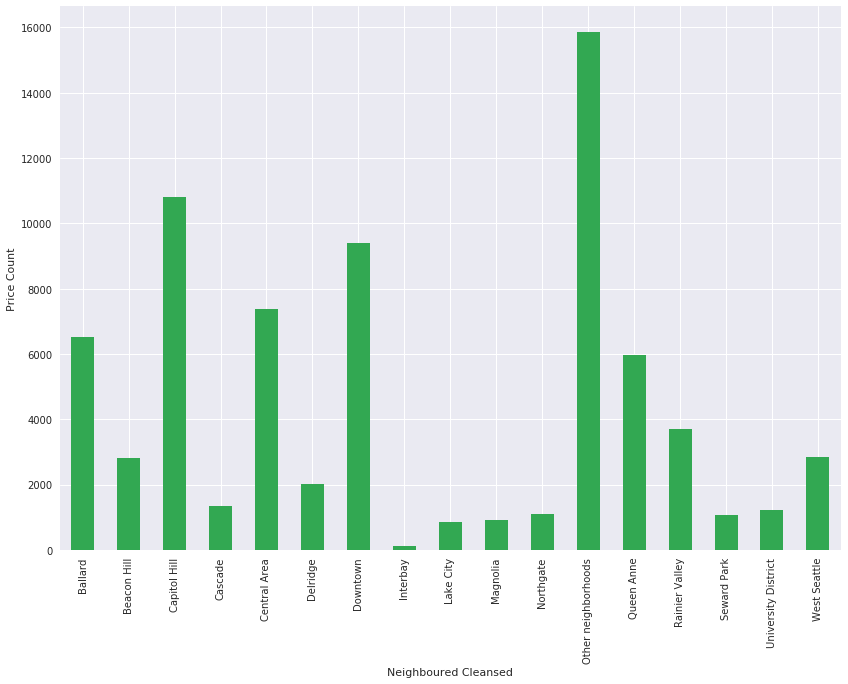

In [44]:
# matplotlib.style.use('ggplot')

neighbourhood_GP = merged_fill_df.groupby('neighbourhood_group_cleansed').price.count()
neighbourhood_GP.plot(kind='bar', 
          x='neighbourhood_group_cleansed',
          y='price',
          color = '#32a852', 
          figsize =(14,10), 
          legend = False)
plt.xlabel('Neighboured Cleansed')
plt.ylabel('Price Count')

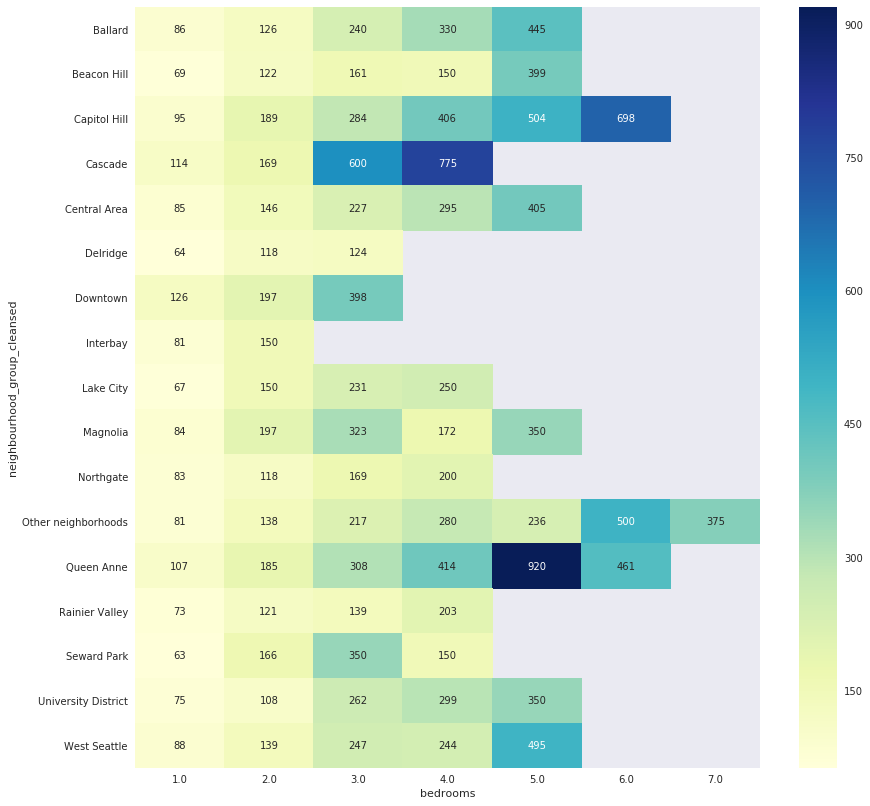

In [45]:
plt.figure(figsize=(14,14))
sns.heatmap(merged_fill_df.groupby([
        'neighbourhood_group_cleansed', 'bedrooms']).price.mean().unstack(),cmap = 'YlGnBu',annot=True, fmt=".0f");

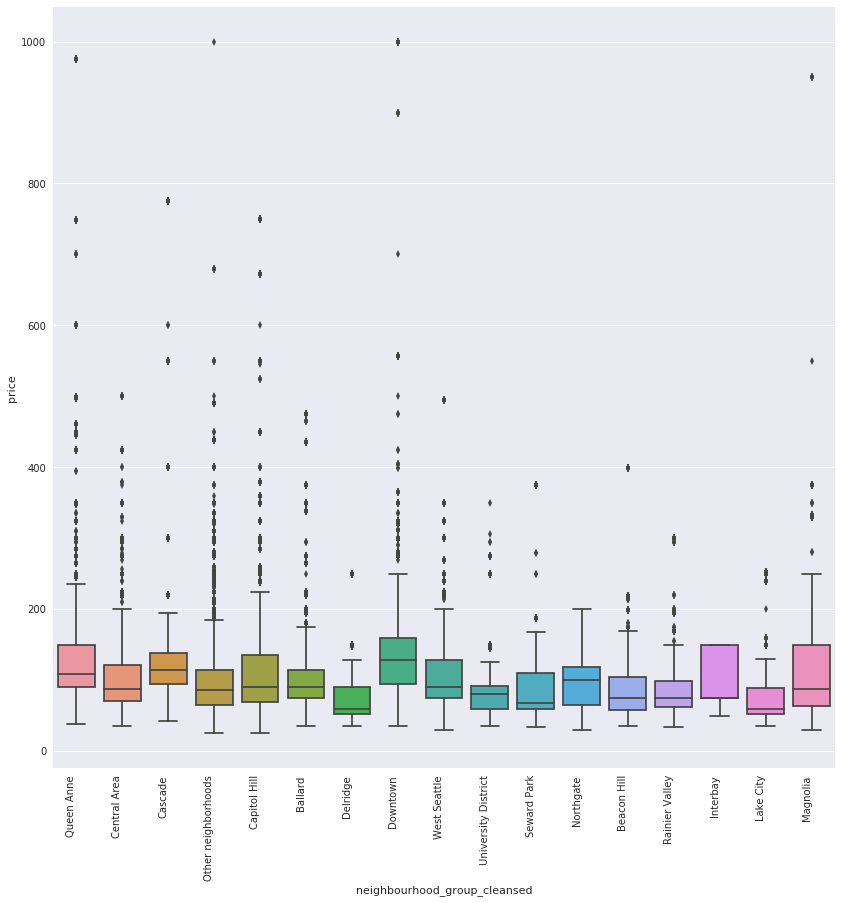

In [46]:
# Explorer the relationship between price and neighbourhood

plt.figure(figsize=(14,14))
# sns.heatmap(merged_fill_df.groupby([
#         'neighbourhood_group_cleansed', 'bedrooms']).price.mean().unstack(),cmap = 'RdYlGn_r',annot=True, fmt=".0f")

sns.boxplot(x='neighbourhood_group_cleansed',y='price',data=merged_fill_df)
ax=plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

# merged_fill_df.head()

In [47]:
# Features considered
num_cols = "property_type,room_type,price,weekly_price,monthly_price".split(",")

# selecting data for limited features
seattle_lists_few= seattle_lists[num_cols]

# Converting string classes to float type for price, weekly_price and monthly_price
seattle_lists_few['price'] = seattle_lists['price'].replace('[\$,]', '', regex=True).astype(float)
seattle_lists_few['weekly_price'] = seattle_lists['weekly_price'].replace('[\$,]', '', regex=True).astype(float)
seattle_lists_few['monthly_price'] = seattle_lists['monthly_price'].replace('[\$,]', '', regex=True).astype(float)

# Summarizing data by room_type and calculating mean, min and max of all numerical features
res1 = seattle_lists_few.groupby(["room_type"], sort=True) \
.agg({'price' : ['mean','min','max'], 'weekly_price' : ['mean','min','max'], 'monthly_price' : ['mean','min','max']});

# Summarizing data by property_type and calculating mean, min and max of all numerical features
res2 = seattle_lists_few.groupby(["property_type"], sort=True) \
         .agg({'price' : ['mean','min','max']});

# Sorting the data by mean from both result sets
print(res1.sort_values([('price', 'mean')], ascending=False))
print(res2.sort_values([('price', 'mean')], ascending=False))

                      price               weekly_price                 \
                       mean   min     max         mean    min     max   
room_type                                                               
Entire home/apt  155.843369  39.0  1000.0   960.996255  250.0  6300.0   
Private room      75.044828  20.0   399.0   462.566775  100.0  2500.0   
Shared room       47.547009  22.0   118.0   285.233333  150.0   915.0   

                monthly_price                  
                         mean    min      max  
room_type                                      
Entire home/apt   3138.630814  800.0  19500.0  
Private room      1556.602273  500.0   9000.0  
Shared room        899.088889  550.0   2400.0  
                      price               
                       mean    min     max
property_type                             
Boat             282.375000   75.0   775.0
Condominium      151.109890   50.0   700.0
Loft             135.700000   25.0   425.0
House          

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

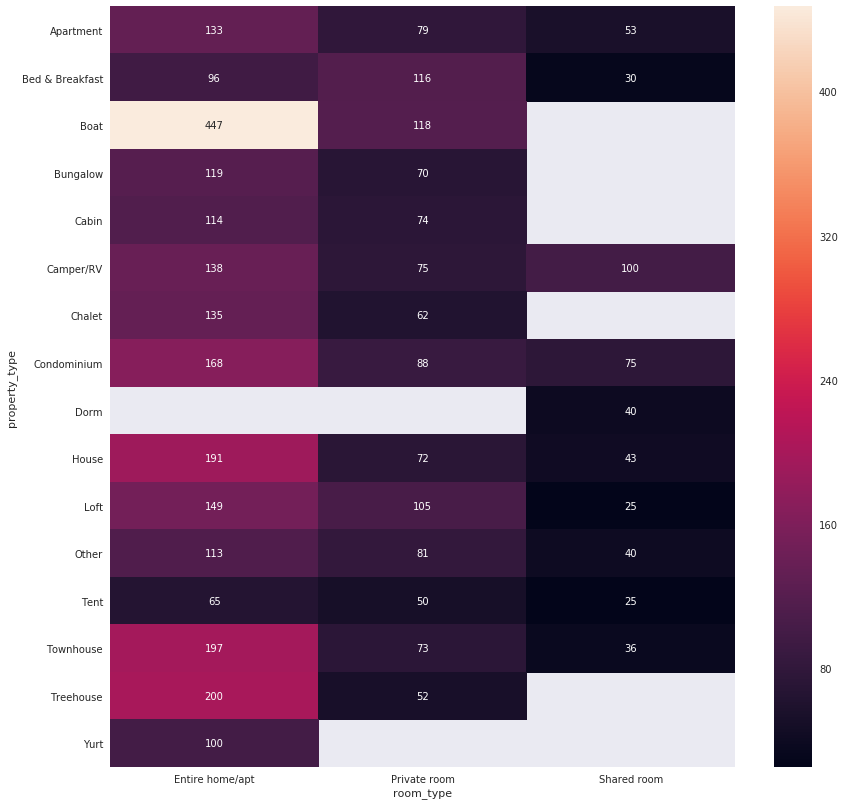

In [48]:
import seaborn as sns

plt.figure(figsize=(14, 14))
sns.heatmap(seattle_lists_few.groupby(['property_type', 'room_type']).price.mean().unstack(), annot=True, fmt='.0f');

# sns.heatmap(merged_fill_df.groupby([
#         'neighbourhood_group_cleansed', 'bedrooms']).price.mean().unstack(),cmap = 'RdYlGn_r',annot=True, fmt=".0f")

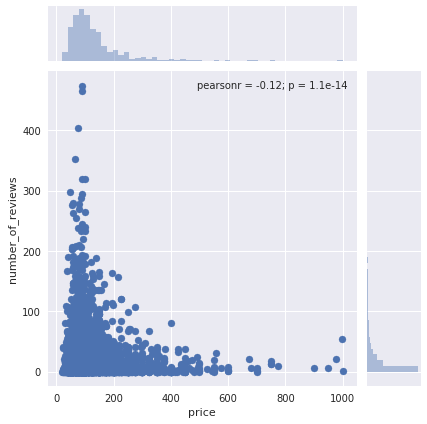

In [49]:
# What's the correlation between price and # of reviews

# seattle_lists[['price','number_of_reviews']].head()

# seattle_lists.columns
# plt.subplots(figsize=(12,12))
seattle_lists['price'] = seattle_lists['price'].replace('[\$,]','',regex=True).astype(float)
price_reviews=seattle_lists[['price','number_of_reviews']]
# plt.figure(figsize=(16, 16))


sns.jointplot('price','number_of_reviews',data=price_reviews);

It is observed that the better review scores are for lesser prices properties ,showing that the guests look for economical options when they choose airbnb .Lesser price is basically appreciated. We need to check what is it that the high priced properties have in them making the price higher.

6 To do this we thought of analysing the description of these particular hosts who had listed their property. So the analysis of the description goes as follows. We have used the 'description' column. Here we are trying to find the words that have maximum frequency. To find out the reasons for high prices.

Some rows have missing values for bathrooms and bedrooms. These are numerical values that can be imputed. There aren't lot of missing values and given that values for bathrooms and bedrooms are small in range (0-8), we can safely use the average for them.


Accommodates and bedrooms have the strongest positive correlation to price. Let's use regressions to validate the positive correlations.


The takeaway from these plots is that the more people the rental can accommodates and the more bedrooms it has, the higher the price.

# Does latitude and longitude have any influence on the price?

In [12]:
# geo_cols_of_interest = "price,longitude,latitude".split(",")

clean_geo_data = seattle_lists[['latitude','longitude','price','minimum_nights','number_of_reviews','reviews_per_month','availability_365','calculated_host_listings_count']]
clean_geo_data = clean_geo_data.dropna(axis=0)
clean_geo_data['price'] = clean_geo_data['price'].replace('[\$,]','',regex=True).astype(float)

In [13]:
clean_geo_data.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count
0,47.636289,-122.371025,85.0,1,207,4.07,346,2
1,47.639123,-122.365666,150.0,2,43,1.48,291,6
2,47.629724,-122.369483,975.0,4,20,1.15,220,2
4,47.632918,-122.372471,450.0,1,38,0.89,365,1
5,47.630525,-122.366174,120.0,1,17,2.45,302,1


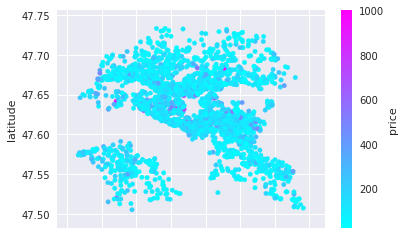

In [14]:
clean_geo_data.plot.scatter(x='longitude', y='latitude', c='price',cmap='cool');

In [15]:
# X be the independent variable and y the dependent variable

X = clean_geo_data.iloc[:, :-1].values

y = clean_geo_data.iloc[:,-1].values

In [16]:
len(X)

3191

In [17]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 20, random_state = 0)
regressor.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [18]:
# Predicting the Test set results
y_pred = regressor.predict(X)
y_pred

array([ 1.7 ,  5.  ,  1.95, ...,  2.45,  4.2 ,  1.3 ])

In [19]:
regressor.score(X,y)

0.9200098445676983

Conclusion
Most of the rooms have listing price below $325/night 
Leather District, South Waterfront, Downtonw area have the highest median listing prices.
Hyde Park, Mattapan and Dorchester areas have the lowest median listing prices.
Rooms in boats have the highest median listing price, rooms in dorms have the lowest median listing price.

## How is the price varying during various times of the year?

In [20]:
# Evaluating date an price for this analysis. Null values have been dropped earlier!

print(merged_fill_df.shape)

merged_fill_df.price.unique()

(73942, 21)


array([   75.,    90.,    55.,    65.,   100.,    40.,    49.,    93.,
         129.,   135.,    60.,   180.,    85.,   150.,    94.,    69.,
         225.,   175.,   169.,   119.,   110.,    95.,   156.,   101.,
          89.,   120.,    50.,    62.,   245.,    30.,    84.,    42.,
         260.,   122.,   209.,    80.,   300.,   219.,   249.,    97.,
         170.,   144.,   348.,   215.,   350.,    37.,    39.,   139.,
         189.,   165.,    70.,   149.,   115.,   168.,   250.,    64.,
          58.,   151.,   179.,   127.,    59.,    68.,   125.,   200.,
         195.,   105.,    99.,   239.,   188.,   259.,   108.,   155.,
         257.,    51.,   280.,    82.,   140.,   600.,   950.,   395.,
          34.,    45.,   359.,   680.,   275.,    53.,   130.,   128.,
         375.,   145.,   265.,    79.,   126.,   116.,   220.,    66.,
          67.,   142.,    87.,   557.,   190.,    91.,   550.,   193.,
          63.,    81.,   182.,    41.,   450.,   210.,   117.,   196.,
      

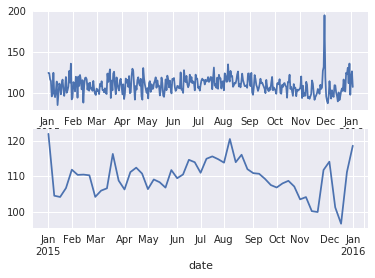

In [21]:

merged_fill_df = merged_fill_df[merged_fill_df['date'] > '2015-01-01']
pricedf = merged_fill_df.groupby(['date'])['price'].mean()

plt.subplot(211)
pricedf.resample('D').mean().plot()
plt.subplot(212)
pricedf.resample('W').mean().plot()

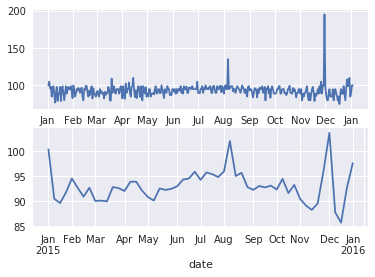

In [23]:
pricedf = merged_fill_df.groupby(['date'])['price'].median()
plt.subplot(211)
pricedf.resample('D').mean().plot()
plt.subplot(212)
pricedf.resample('W').mean().plot()

Conclusion:

Assessed 2015/2016 data only for and the trend is quite clear. 

As we could see from the line graph, it seems that the busiest season of Seattle in a year is around December/NewYear into January time and again in summer, the price keeps going high from December into January with peak (117 average, 99 median) and reached high again in July/August timeframe. The average of the listing price increased by 25% compared to the low time of the year.



### Categorical features assessment

Have employed various methods such as visually verifying the data, plotting the data for example using sns.pairplot and heatmaps, much of the categorical feature have been removed. Most of the categorial features have several hundred classes in them for example, such as listing_url, space, summary, name etc have hundreds of classes which will not help in identifying the relation to the price. Features such as property_type which has about 15 unique classes and likewise other categorical features have been considered for the model. 

**All categorical variables have been verified for data completeness and validity**

In [35]:
cols = ['host_has_profile_pic', 'host_identity_verified','room_type', 'bed_type', 'price', 'instant_bookable',
       'cancellation_policy', 'require_guest_phone_verification']

cat_cols_fin = []
# Excluding features that have more than 15 unique classes within, except for the depedent variable price

for c in cols:
    if seattle_lists[c].nunique() < 15 or c == 'price':
        cat_cols_fin.append(c)
    else:
        print("\nexcluding - ", c, " - ", seattle_lists[c].nunique(), '\n')

# Numerical features considered based on the score from the above step        
num_cols = ['beds', 'bedrooms', 'bathrooms', 'review_scores_rating', 'host_listings_count' ]

# Merging numerical and categorical features
cat_cols_fin.extend(num_cols)

'''
There are a total of 21 cols identified that has greater degree of correlation with the price

In the next step, these cols are being fed into a func which will further create dummy cols for all 
categorical variables
'''


# #start clean up 
print(cat_cols_fin, len(cat_cols_fin))
print(seattle_lists[cat_cols_fin].head())


['host_has_profile_pic', 'host_identity_verified', 'room_type', 'bed_type', 'price', 'instant_bookable', 'cancellation_policy', 'require_guest_phone_verification', 'beds', 'bedrooms', 'bathrooms', 'review_scores_rating', 'host_listings_count'] 13
  host_has_profile_pic host_identity_verified        room_type  bed_type  \
0                    t                      t  Entire home/apt  Real Bed   
1                    t                      t  Entire home/apt  Real Bed   
2                    t                      t  Entire home/apt  Real Bed   
3                    t                      t  Entire home/apt  Real Bed   
4                    t                      t  Entire home/apt  Real Bed   

   price instant_bookable cancellation_policy  \
0   85.0                f            moderate   
1  150.0                f              strict   
2  975.0                f              strict   
3  100.0                f            flexible   
4  450.0                f              strict   

 

In [36]:
# This function will assist in cleaning up the dataset

def clean_data(df, col_list, incl_dependent=False):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with NaN values
    2. Create X as all the columns that is not the Price column
    3. Create y as the Price column
    4. Drop the Price columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    
    # Convert price from string to float 
    y = df['price'].replace('[\$,]', '', regex=True).astype(float)
    
    #Taking just those features that are finalized (from the step above)
    df = df[col_list]
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables except for the price
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        if var != 'price':
        # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
#     Removing the price from the dataframe df
    if incl_dependent:
        df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
    else:
        del df['price']

    X = df
    return X, y
    
#Use the function to create X and y
# print(cat_cols_fin)
X, y = clean_data(seattle_lists, cat_cols_fin)
# print(X.head())

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [37]:
'''
Linear model to help regress the features considered onto the price
'''

# Split data into training and test data, and fit a linear model
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X, y , test_size=.30, random_state=42)
lm_2_model = LinearRegression(normalize=True)

# print(X_2_train.columns)

# If our model works, it should just fit our model to the data. Otherwise, it will let us know.
try:
    lm2 = lm_2_model.fit(X_2_train, y_2_train)
    print(lm2.intercept_)
    print(lm2.coef_)
    
except Exception as e:
    print(e)
    print("Oh no! It didn't work!!!")
    

13.7497185899
[  9.89987034e+00   3.13979348e+01   3.53225713e+01   4.56271397e-01
   5.01057060e-02  -1.19237986e+01  -4.64532990e-01  -5.06654223e+01
  -8.20915073e+01   8.90592191e+00  -3.15020227e+00  -9.58599295e-01
   7.56639912e-01  -5.92740961e+00  -9.02169033e+00   1.57505630e+00
   8.85199462e+00]


In [38]:
# Verifying the results and r2 score

y_test_preds = lm_2_model.predict(X_2_test)# Predictions here
r2_test = r2_score(y_2_test, y_test_preds) # Rsquared here

# Print r2 to see result
r2_test

0.55435727215236219

### Evaluate the result:

It appears that 55% of the variability of the price can be explained by the features considered and the remaining 45%
variability may or may not be explained with the dataset considered

Few features like scrape_id are either entirely null or have just one value on all rows which makes it is unnecesary. 

Several such features have been removed

Based on intuition and futher inspection variables such as license, requires_license, host_name, host_has_profile_pic, host_verifications, host_neighborhood, require_guest_profile_picture, require_guest_phone_verification, host_location, weekly_price, monthly_price, first_review, last_review, jurisdiction_names, street, market, cleaning_fee, transit, house_rules, host_about, neighborhood_overview, host_neighborhood, name, interaction, access, space, notes, summary, description,  transit, neighborhood_overview and security_deposit - have no real value to our analysis and therefore have been removed


# Evaluate the result¶
Based on the data visualization in Tableau, the prediction model and the sentiment analysis, we can come up with observations as below:

The model of 10 variables: 5 continuous and 5 categorical variables can explain around 54% of the listing price in the dataset. Location is one of a factor affecting listing price
Occupancy rate tends to be higher in summer;
Hosts can earn money with their Airbnb venture;
Overall, Airbnb hosts receive good ratings although super hosts tend to rank higher than regular hosts
And a majority of guests have positive experience with their Airbnb experience


**Reference and Credit**
Visualizing Data with Pairs Plots in Python - Will Koehrsen
A Complete Exploratory Data Analysis and Visualization for Text Data - Susan Li
Hands-on Machine Learing with Scikit-Learn and TensorFlow - Aurelien Geron

# In order to anaylize the trend of the housing price and identify when the busiest timing is, several steps are performed below:

Cleaning the data for aggregation and visualization
Visualize the time trend of the data
Calculate by how much the price spikes and if there's some outliers